In [47]:
import nltk
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [49]:
df = df[['Sentiment','text']]

In [50]:
df.columns

Index(['Sentiment', 'text'], dtype='object')

In [51]:
df.Sentiment.value_counts()

0    799996
4    248576
Name: Sentiment, dtype: int64

In [52]:
df['Sentiment'] = df['Sentiment'].replace({4:1})

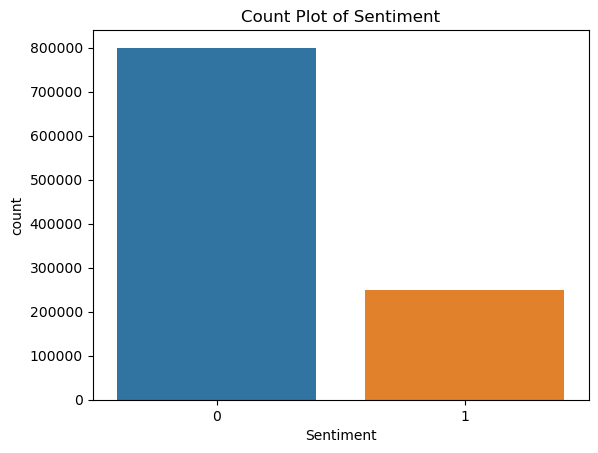

In [53]:
sns.countplot(df["Sentiment"])
plt.title("Count Plot of Sentiment")
plt.show()

In [54]:
df.isna().sum().sum()

0

In [55]:
from sklearn.utils import resample

In [56]:
df_majority = df[df['Sentiment']==0]
df_minority = df[df['Sentiment']==1]

In [57]:
df_minority.shape

(248576, 2)

In [58]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,   
                                 n_samples=len(df_minority),    
                                 random_state=1234)

In [59]:
df = df_majority_downsampled.append(df_minority)
df.head()

,Sentiment,text
74567,0,Wow slept for almost 12hours. Sleepy me!! Uni ...
668722,0,gets bored with an idea too easily ... like tw...
286706,0,To my girls - sorry i've been a homebody latel...
632911,0,BK once again for the weekend...If it wasnt fo...
356735,0,@DonnieWahlberg Now why didn't you do that las...


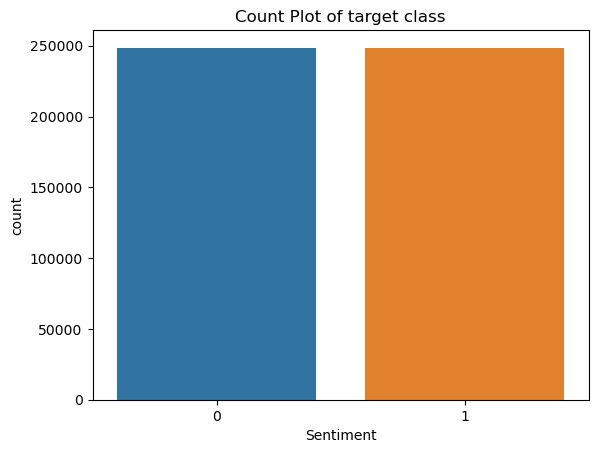

In [60]:
sns.countplot(df["Sentiment"])
plt.title("Count Plot of target class")
plt.show()

In [61]:
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()

corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

497152
Wow slept for almost 12hours. Sleepy me!! Uni now, boo! I wanna stay home, drink tea and watch house... 


In [62]:
%%time
final_corpus = []
final_corpus_joined = []
for i in df.index:

    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    #Convert to lowercase
    text = text.lower()
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text 
            if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

Wall time: 1min 16s


In [63]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["Sentiment"] = df["Sentiment"].values

In [64]:
data_cleaned['Sentiment'].value_counts()

0    248576
1    248576
Name: Sentiment, dtype: int64

In [65]:
data_cleaned.head()

,text,Sentiment
0,wow slept almost hour sleepy uni boo wanna sta...,0
1,get bored idea easily like twitter,0
2,girl sorry homebody lately dont feel well does...,0
3,bk weekend wasnt puppy stay as,0
4,donniewahlberg last night atlanta,0


In [66]:
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['Sentiment'] = df["Sentiment"].values
data_eda.head()

,text,Sentiment
0,"[wow, slept, almost, hour, sleepy, uni, boo, w...",0
1,"[get, bored, idea, easily, like, twitter]",0
2,"[girl, sorry, homebody, lately, dont, feel, we...",0
3,"[bk, weekend, wasnt, puppy, stay, as]",0
4,"[donniewahlberg, last, night, atlanta]",0


In [67]:
# Storing positive data seperately
positive = data_eda[data_eda['Sentiment'] == 1]
positive_list = positive['text'].tolist()

# Storing negative data seperately

negative = data_eda[data_eda['Sentiment'] == 0]
negative_list = negative['text'].tolist()

In [68]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

In [69]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1    
            
    return(dic)
count_corpus = get_count(positive_list)

In [70]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

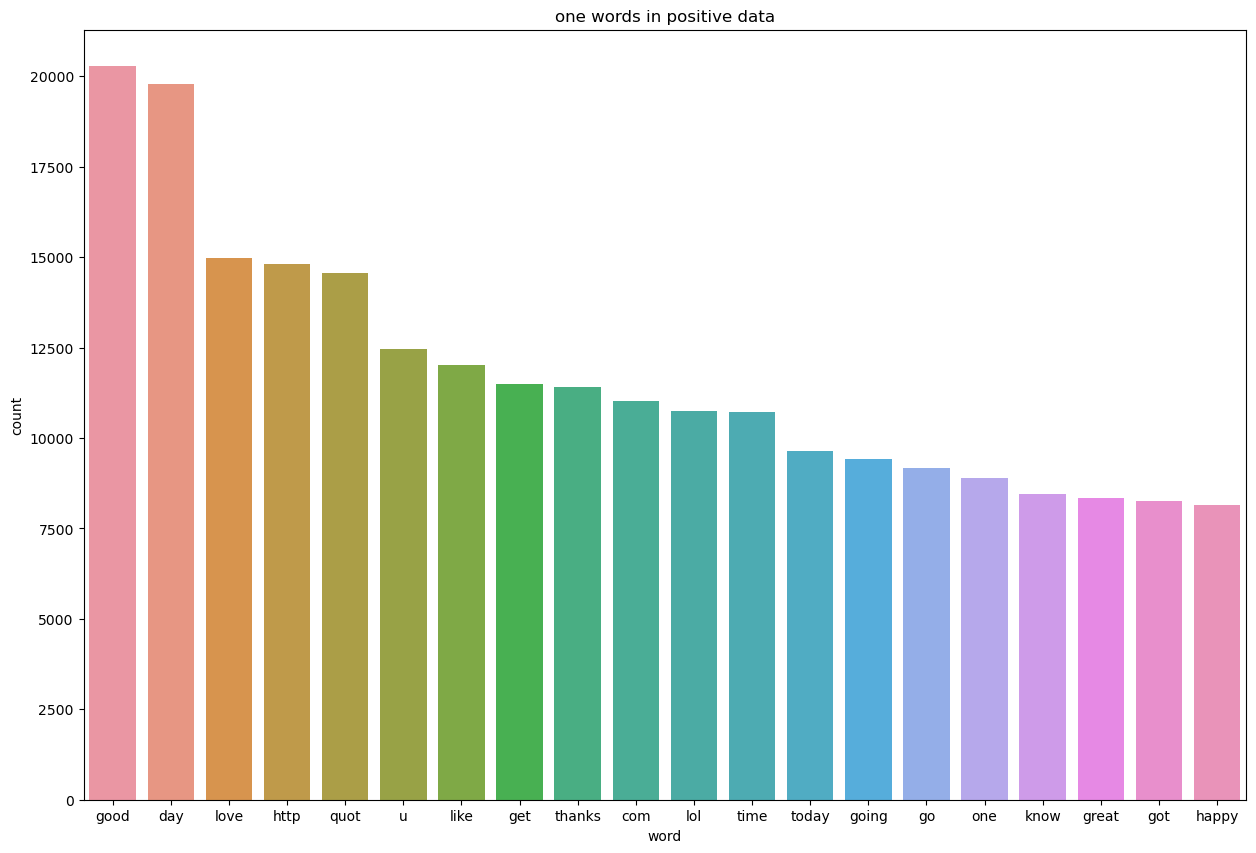

In [71]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in positive data')
plt.show()

In [72]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1    
            
    #dic = dict(sorted(dic.items() , key = lambda x:x[1],reverse=True))
    return(dic)
count_corpus = get_count(negative_list)

In [73]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

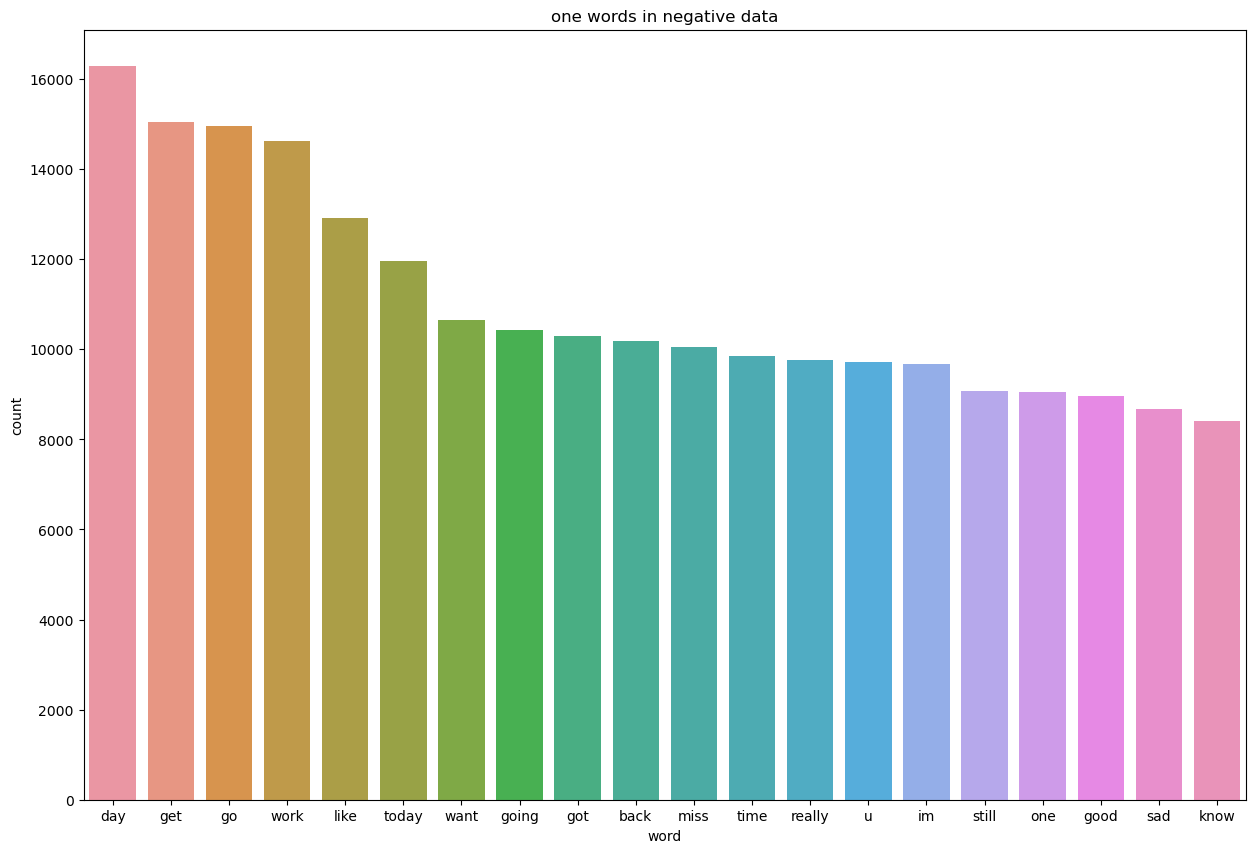

In [74]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in negative data')
plt.show()

In [75]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_list)
negative_tokens_for_model = get_tweets_for_model(negative_list)

In [76]:
import random

positive_dataset = [(review_dict, "Positive")
                     for review_dict in positive_tokens_for_model]

negative_dataset = [(review_dict, "Negative")
                     for review_dict in negative_tokens_for_model]
dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:333091]
test_data = dataset[333091:]

In [77]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print(" Training Accuracy is:", round(classify.accuracy(classifier, train_data),2)*100)

print("Testing Accuracy is:", round(classify.accuracy(classifier, test_data),2)*100)

print(classifier.show_most_informative_features(10))

 Training Accuracy is: 86.0
Testing Accuracy is: 76.0
Most Informative Features
                    iran = True           Negati : Positi =     51.3 : 1.0
                 fawcett = True           Negati : Positi =     47.6 : 1.0
                sprained = True           Negati : Positi =     35.0 : 1.0
                hotwords = True           Positi : Negati =     33.7 : 1.0
              devastated = True           Negati : Positi =     29.0 : 1.0
                   lvatt = True           Negati : Positi =     27.0 : 1.0
                nauseous = True           Negati : Positi =     27.0 : 1.0
                  farrah = True           Negati : Positi =     26.7 : 1.0
                  boohoo = True           Negati : Positi =     26.3 : 1.0
                  booooo = True           Negati : Positi =     26.3 : 1.0
None


In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(data_cleaned['text'])
y = data_cleaned['Sentiment']

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify = y)

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

In [81]:
def metrics(y_train,y_train_pred,y_test,y_test_pred):
  print("training accuracy = ",round(accuracy_score(y_train,y_train_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize = 'all')
  print(classification_report(y_train,y_train_pred))
  plt.show()

  print("testing accuracy = ",round(accuracy_score(y_test,y_test_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,normalize = 'all')
  print(classification_report(y_test,y_test_pred))
  plt.show()

training accuracy =  85.0
              precision    recall  f1-score   support

           0       0.83      0.88      0.85    166545
           1       0.87      0.82      0.85    166546

    accuracy                           0.85    333091
   macro avg       0.85      0.85      0.85    333091
weighted avg       0.85      0.85      0.85    333091



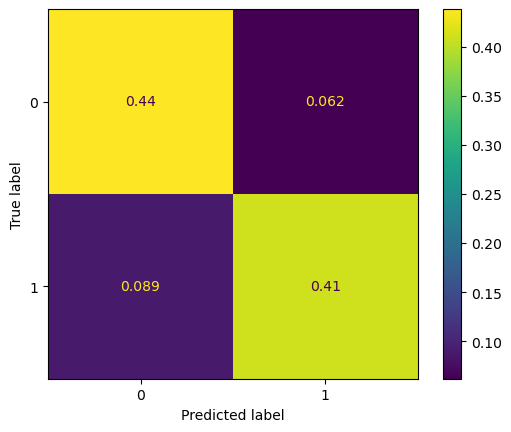

testing accuracy =  76.0
              precision    recall  f1-score   support

           0       0.75      0.80      0.77     82031
           1       0.78      0.73      0.75     82030

    accuracy                           0.76    164061
   macro avg       0.76      0.76      0.76    164061
weighted avg       0.76      0.76      0.76    164061



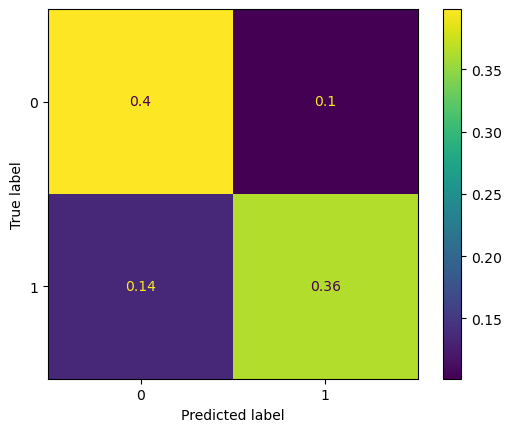

In [82]:
NB = MultinomialNB()
NB.fit(X_train,y_train)
y_train_pred = NB.predict(X_train)
y_test_pred = NB.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

training accuracy =  90.0
              precision    recall  f1-score   support

           0       0.90      0.90      0.90    166545
           1       0.90      0.90      0.90    166546

    accuracy                           0.90    333091
   macro avg       0.90      0.90      0.90    333091
weighted avg       0.90      0.90      0.90    333091



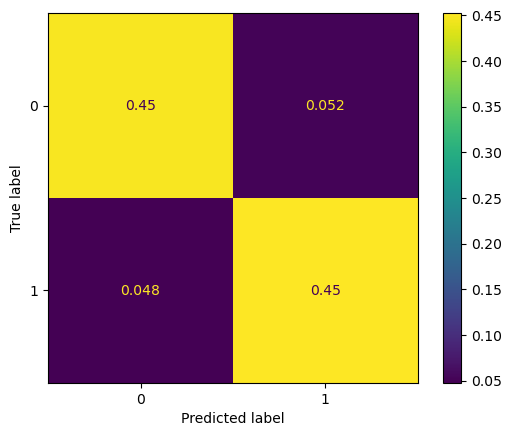

testing accuracy =  77.0
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     82031
           1       0.76      0.78      0.77     82030

    accuracy                           0.77    164061
   macro avg       0.77      0.77      0.77    164061
weighted avg       0.77      0.77      0.77    164061



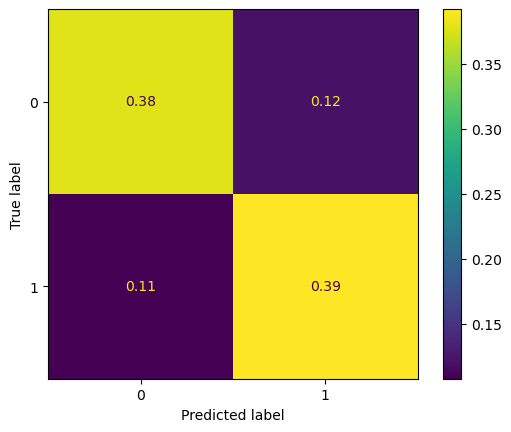

In [83]:
svc = LinearSVC()
svc.fit(X_train,y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

training accuracy =  83.0
              precision    recall  f1-score   support

           0       0.84      0.81      0.82    166545
           1       0.82      0.84      0.83    166546

    accuracy                           0.83    333091
   macro avg       0.83      0.83      0.83    333091
weighted avg       0.83      0.83      0.83    333091



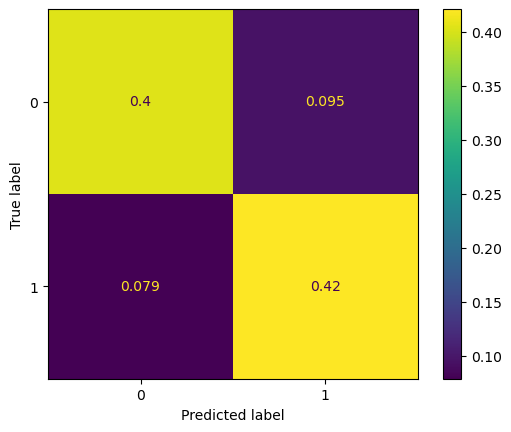

testing accuracy =  78.0
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     82031
           1       0.77      0.80      0.78     82030

    accuracy                           0.78    164061
   macro avg       0.78      0.78      0.78    164061
weighted avg       0.78      0.78      0.78    164061



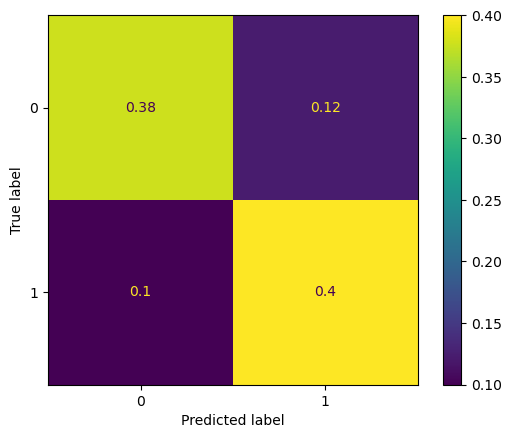

In [84]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)